In [221]:
!pip install -U cofi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


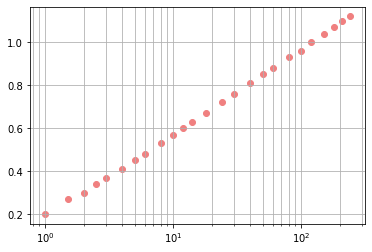

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# here is some (x,y) data
data_x = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 24.0, 30.0, 40.0, 50.0, 60.0, 80.0, 
                   100.0, 120.0, 150.0, 180.0, 210.0, 240.0])
data_y = np.array([0.20, 0.27, 0.30, 0.34, 0.37, 0.41, 0.45, 0.48, 0.53, 0.57, 0.60, 0.63, 0.67, 0.72, 0.76, 0.81, 0.85, 0.88, 
                   0.93, 0.96, 1.00, 1.04, 1.07, 1.10, 1.12])
sigma = 0.1

def plot_data(sigma=None):
    if sigma is None:
        plt.scatter(data_x, data_y, color="lightcoral", label="observed data")
    else:
        plt.errorbar(data_x, data_y, yerr=sigma, fmt='.',color="lightcoral",ecolor='lightgrey',ms=10)
    plt.xscale("log")
    plt.grid(True, which="both")
plot_data()

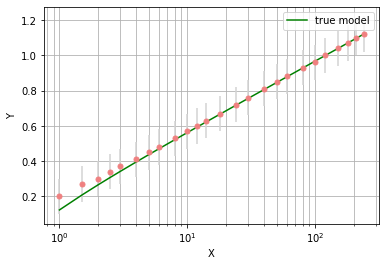

In [223]:
nparams = 2

#def jacobian(x=data_x, n=nparams):
#    return np.array([x**i for i in range(n)]).T

def forward(model):
    from scipy.special import expi
    global Q,r
    result = np.array([Q/4./np.pi/10.**model[0]*-expi(r**2.*10.**model[1]/4./10.**model[0]/t) for t in data_x/1440.])
    result[result==-np.inf] = 0.
    result[result== np.inf] = 0.
    return result

def Cd_inv(sigma=sigma, ndata=len(data_x)):
    return 1/sigma**2. * np.identity(ndata)

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ Cdinv @ residual.T

m_lower_bound = np.array([-1.0, -10.0])             # lower bound for uniform prior
m_upper_bound = np.array([ 4.0,   0.0])             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

# True model for plotting
x = data_x                             # x values to plot
true_model = np.array([3.087, -3.699])  # we know it for this case which will be useful later for comparison.
Q,r = 31.0/1000.*86400., 61.0          # convert 31 L/s to m3/d
true_y = forward(true_model)           # y values for true curve

# Some plotting utilities
def plot_model(x, y, label, color=None):
    plt.plot(x, y, color=color or "green", label=label)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1):
    plt.plot(x, forward(models[0]), color=color, label=label, alpha=alpha)
    for m in models:
        plt.plot(x, forward(m), color=color, alpha=alpha)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
plot_data(sigma=sigma)
plot_model(x, true_y, "true model")

In [224]:
from cofi import BaseProblem, InversionOptions, Inversion

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
#inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

inv_options = InversionOptions()

nwalkers = 32
ndim = nparams
nsteps = 5000
walkers_start = np.vstack([ 3.0+0.1*np.random.randn(nwalkers),
                           -4.0+0.1*np.random.randn(nwalkers)]).T

######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_walkers_starting_pos(walkers_start)

######## CoFI InversionOptions - get a different tool
inv_options = InversionOptions()
inv_options.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True)

######## CoFI Inversion - run it
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result.summary()

100%|██████████| 5000/5000 [00:27<00:00, 183.66it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


In [225]:
import arviz as az
labels = ["m0", "m1"]
sampler = inv_result.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 5000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
Data variables:
    m0       (chain, draw) float64 2.987 3.011 3.011 3.011 ... 3.172 3.163 3.166
    m1       (chain, draw) float64 -4.106 -4.075 -4.075 ... -4.028 -3.994 -3.995
Attributes:
    created_at:                 2022-12-06T05:45:40.099343
    arviz_version:              0.12.1
    inference_library:          emcee
    inference_library_version:  3.1.3

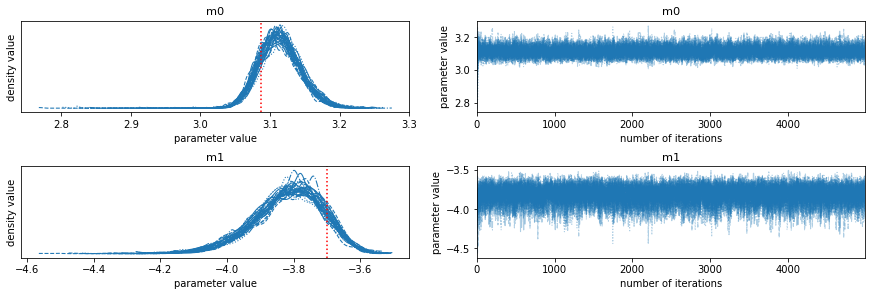

In [226]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [227]:
tau = sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [31.65657661 30.99485083]


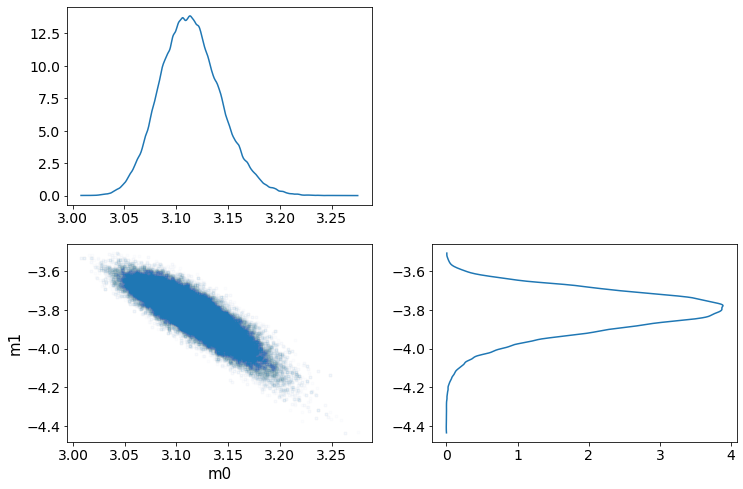

In [228]:
# a Corner plot
fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))
az.plot_pair(az_idata.sel(draw=slice(300,None)), 
             marginals=True, 
             #reference_values=dict(zip([f"m{i}" for i in range(2)], true_model.tolist())),
             scatter_kwargs=dict(alpha=0.01),
             ax=axes);

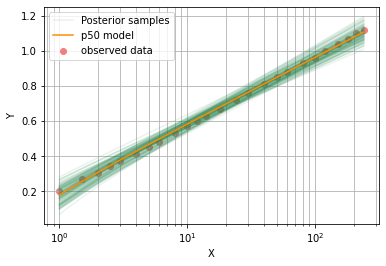

In [229]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data()
plot_models(flat_samples[inds])
#plot_model(x, true_y, "True model", color="darkorange")
plot_model(x, forward([np.percentile(flat_samples[:,0], 50.),
                       np.percentile(flat_samples[:,1], 50.)]), 
           "p50 model", color="darkorange")

In [230]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   3.112 [  3.068,   3.165]
 m1  -3.806 [ -4.003,  -3.660]


In [231]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 0.00086764 -0.00265534]
 [-0.00265534  0.01086284]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.0295
    m1  0.1042
